# Вводная


Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру.

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам.



In [548]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df = pd.read_csv('stud_math.xls')

In [549]:
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

1. school — аббревиатура школы, в которой учится ученик
2. sex — пол ученика ('F' - женский, 'M' - мужской)
3. age — возраст ученика (от 15 до 22)
4. address — тип адреса ученика ('U' - городской, 'R' - за городом)
5. famsize — размер семьи('LE3' <= 3, 'GT3' >3)
6. Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. schoolsup — дополнительная образовательная поддержка (yes или no)
17. famsup — семейная образовательная поддержка (yes или no)
18. paid — дополнительные платные занятия по математике (yes или no)
19. activities — дополнительные внеучебные занятия (yes или no)
20. nursery — посещал детский сад (yes или no)
21. studytime, granular — непонятный столбик с отрицательными значениями
22. higher — хочет получить высшее образование (yes или no)
23. internet — наличие интернета дома (yes или no)
24. romantic — в романтических отношениях (yes или no)
25. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
26. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
27. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
28. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
29. absences — количество пропущенных занятий
30. score — баллы по госэкзамену по математике

# Подготовительный раздел

In [551]:
# фильтруем колонки по DataType, чтоб в будущем использовать в функциях или циклах
numeric_columns = df.dtypes[df.dtypes != "object"].index
object_columns = df.dtypes[df.dtypes == 'object'].index

In [552]:
# Функция для замены пропусков и NaN
def none_func(column):
    df[column] = df[column].astype(str).apply(
        lambda x: None if x.strip() == '' else x)
    df[column] = df[column].apply(lambda x: None if pd.isnull(x) else None if x == 'nan'
                                  else x if'(' not in x else x[:x.find('(')].strip())

In [553]:
# Функция для определения статистических различий
def df_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [554]:
# Функция построения "боксплотов" для графического отображения влияний
def df_boxplot(column):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(x=column, y='score',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Предварительный анализ основного параметра "score"

In [555]:
df.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

In [556]:
df.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

Видим, что 37 учеников или же не сдавали экзамен совсем, или же просто не сдали. Проверим их посещаемость.

In [557]:
df['absences'][df.score == 0]

128    0.0
130    0.0
131    0.0
134    0.0
135    0.0
136    0.0
137    0.0
140    0.0
144    0.0
146    0.0
148    0.0
150    NaN
153    0.0
160    0.0
162    0.0
168    0.0
170    0.0
173    0.0
221    0.0
239    0.0
242    0.0
259    0.0
264    0.0
269    0.0
296    0.0
310    0.0
316    0.0
332    0.0
333    0.0
334    0.0
337    0.0
341    0.0
343    0.0
367    0.0
383    0.0
387    0.0
389    0.0
Name: absences, dtype: float64

Обращаем внимание, что пропусков у подобных студентов нет. Проверим их оценки на выбросы, чтоб понять будут ли они влиять на общую статистику.

In [558]:
median = df.score.median()
IQR = df.score.quantile(0.75) - df.score.quantile(0.25)
perc25 = df.score.quantile(0.25)
perc75 = df.score.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Согласно расчету значения 0 не попадают в зону выбросов, следовательно - пока оставим их. 

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

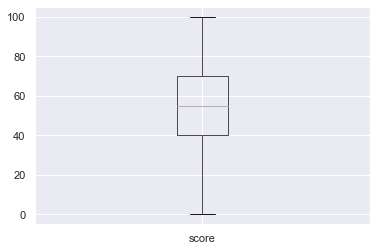

In [559]:
boxplot = df.boxplot(column=['score'])
df.score.describe()

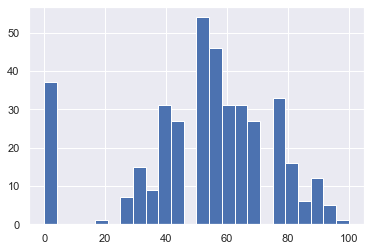

In [560]:
df.score.hist(bins=24)

Как видим, распределение смещено вправо. Т.е. стремящихся учиться хорошо больше. Посмотрим, как распределились результаты оценок по школам 

In [561]:
df.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

В данном сете мы имеем всего лишь две школы. Разница в количестве учеников болле, чем в 7 раз

In [562]:
gp_school = df.loc[df.school == 'GP']
ms_school = df.loc[df.school == 'MS']

# Школа и её влияние на общую статистику оценок

Проверим распределение оценок по школам GP и MS

In [563]:
gp_school.score.value_counts()

50.0     44
55.0     42
0.0      33
75.0     30
40.0     28
60.0     28
70.0     26
65.0     26
45.0     23
80.0     14
30.0     14
90.0     12
35.0      7
85.0      6
25.0      5
95.0      4
100.0     1
20.0      1
Name: score, dtype: int64

In [564]:
ms_school.score.value_counts()

50.0    10
65.0     5
0.0      4
45.0     4
55.0     4
75.0     3
60.0     3
40.0     3
35.0     2
25.0     2
80.0     2
30.0     1
70.0     1
95.0     1
Name: score, dtype: int64

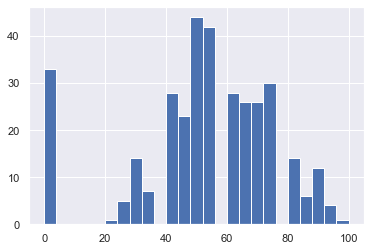

In [565]:
gp_school.score.hist(bins=25)

count    344.000000
mean      52.630814
std       23.116772
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

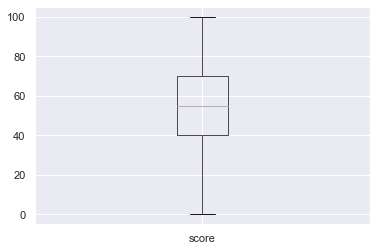

In [566]:
boxplot = gp_school.boxplot(column='score')
gp_school.score.describe()

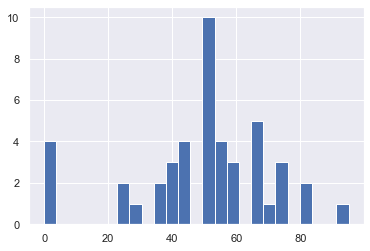

In [567]:
ms_school.score.hist(bins=25)

count    45.000000
mean     49.444444
std      21.379212
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

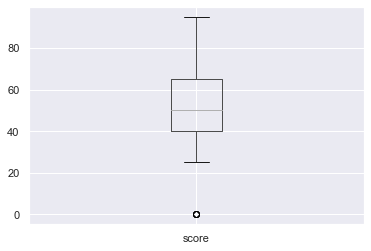

In [568]:
ms_school.boxplot(column='score')
ms_school.score.describe()

In [569]:
ms_school.score.value_counts()

50.0    10
65.0     5
0.0      4
45.0     4
55.0     4
75.0     3
60.0     3
40.0     3
35.0     2
25.0     2
80.0     2
30.0     1
70.0     1
95.0     1
Name: score, dtype: int64

Видим из boxplot, что нулевые значения для школы MS являются явными выбросами. На общую статистику не повлияют, но для чистоты эксперимента удалим их.

In [570]:
# получаем индексы нулевых значений школы MS
ms_index_list = ms_school[ms_school['score'] == 0].index.tolist()

In [571]:
# по полученным индексам удаляем значения их общего DataFrame
for i in ms_index_list:
    df.drop([i], inplace=True)

строим заново гистограмму и боксплот

count    45.000000
mean     49.444444
std      21.379212
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

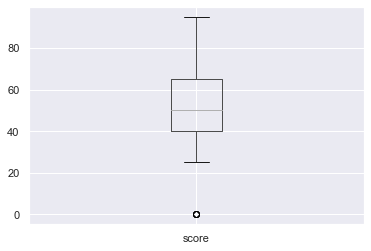

In [572]:
ms_school.boxplot(column='score')
ms_school.score.describe()

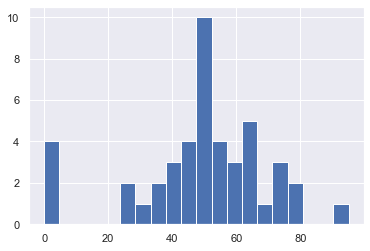

In [573]:
ms_school.score.hist(bins=20)

видим по боксплоту, что оценки для школы MS получили более явное правое смещение.
Врозвращаемся к исходному датасету, уже с учетом удаленных данных по школе MS 

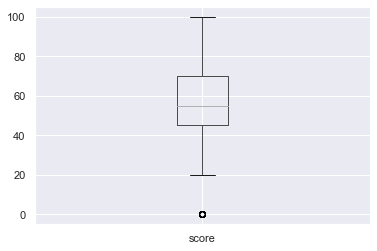

In [574]:
df.boxplot(column=['score'])

видим по боксплоту, что оставшиеся нули в школе GP на общем фоне стали выбросами. Проверим нижнюю границу

In [575]:
median = df.score.median()
IQR = df.score.quantile(0.75) - df.score.quantile(0.25)
perc25 = df.score.quantile(0.25)
perc75 = df.score.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 45.0, 75-й перцентиль: 70.0, IQR: 25.0,  Границы выбросов: [7.5, 107.5].


Да, видим, что нижняя граница сместилась и стала 7.5. Соответственно нули могут быть удалены

In [576]:
# получим индексы нулей
gp_index_list = gp_school[gp_school['score'] == 0].index.tolist()
gp_index_list

[128,
 130,
 131,
 134,
 135,
 136,
 137,
 140,
 144,
 146,
 148,
 150,
 153,
 160,
 162,
 168,
 170,
 173,
 221,
 239,
 242,
 259,
 264,
 269,
 296,
 310,
 316,
 332,
 333,
 334,
 337,
 341,
 343]

In [577]:
# по полученным индексам удаляем значения их общего DataFrame
for i in gp_index_list:
    df.drop([i], inplace=True)

count    352.000000
mean      57.755682
std       16.200928
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

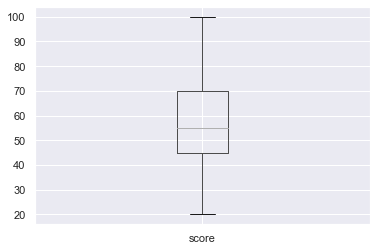

In [578]:
df.boxplot(column=['score'])
df.score.describe()

Общее распределение тоже получило более явное смещение вправо. Медиана осталась прежней

Проверим в процентном соотношении качество учёбы по школам

In [579]:
ms_75 = ms_school[ms_school.score > 75]
ms_good_perc = round((ms_75.score.count()*100)/ms_school.score.count(), 1)

gp_75 = gp_school[gp_school.score > 75]
gp_good_perc = round((gp_75.score.count()*100)/gp_school.score.count(), 1)

print('Процент хорошистов/отличников в школе GP = {}, в школе MS = {}'.format(gp_good_perc, ms_good_perc))

Процент хорошистов/отличников в школе GP = 10.8, в школе MS = 6.7


Возможно школа GP более внимательно подходит к образованию, либо же на оценки влияют доплнительные факторы.

# Влияние пола на оценку

In [580]:
# обновляем переменные, так как удаляли из основного сета нули.
gp_school = df.loc[df.school == 'GP']
ms_school = df.loc[df.school == 'MS']

In [581]:
df.sex.value_counts()

F    186
M    172
Name: sex, dtype: int64

суммарно по двум школам у нас дквочек больше на 14, чем мальчиков

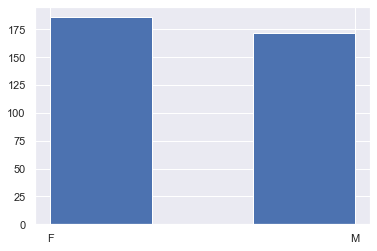

In [582]:
df.sex.hist(bins=3)

Проверим распределение по школам.

F    22
M    20
Name: sex, dtype: int64

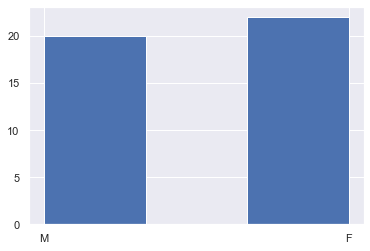

In [583]:
ms_school.sex.hist(bins=3)
ms_school.sex.value_counts()

F    164
M    152
Name: sex, dtype: int64

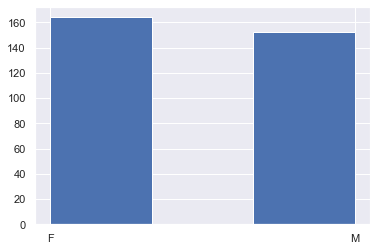

In [584]:
gp_school.sex.hist(bins=3)
gp_school.sex.value_counts()

Девочек везде больше, но незначительно, что отвергает вероятность гендерно-ориентированных школ.
Проверим влияние пола на оценки

# Пол в школе MS

count    22.000000
mean     56.363636
std      16.488222
min      25.000000
25%      50.000000
50%      52.500000
75%      65.000000
max      95.000000
Name: score, dtype: float64

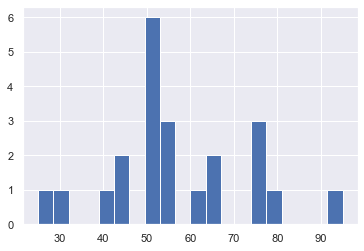

In [585]:
display(ms_school[ms_school.sex == 'F'].score.describe())
ms_school[ms_school.sex == 'F'].score.hist(bins=20)

count    19.000000
mean     51.842105
std      13.865477
min      25.000000
25%      42.500000
50%      50.000000
75%      62.500000
max      80.000000
Name: score, dtype: float64

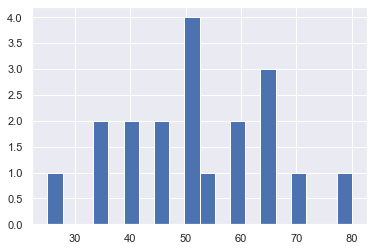

In [586]:
display(ms_school[ms_school.sex == 'M'].score.describe())
ms_school[ms_school.sex == 'M'].score.hist(bins=20)

In [587]:
ms_school.score.value_counts()

50.0    10
65.0     5
45.0     4
55.0     4
75.0     3
60.0     3
40.0     3
35.0     2
25.0     2
80.0     2
30.0     1
70.0     1
95.0     1
Name: score, dtype: int64

# Пол в школе GP

count    160.000000
mean      56.125000
std       15.949508
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

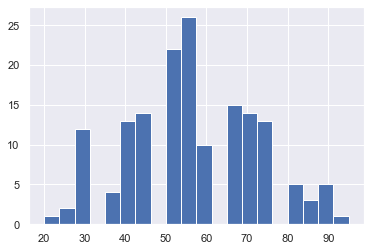

In [588]:
display(gp_school[gp_school.sex == 'F'].score.describe())
gp_school[gp_school.sex == 'F'].score.hist(bins=20)

count    151.000000
mean      60.430464
std       16.390448
min       25.000000
25%       50.000000
50%       60.000000
75%       75.000000
max      100.000000
Name: score, dtype: float64

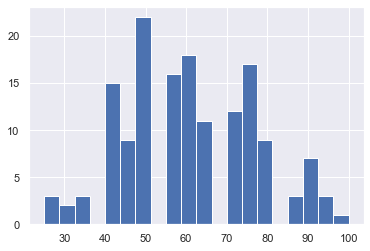

In [589]:
display(gp_school[gp_school.sex == 'M'].score.describe())
gp_school[gp_school.sex == 'M'].score.hist(bins=20)

Для отображения общей картины по оценкам, основанным на гендерных различиях построем сводную диаграмму.

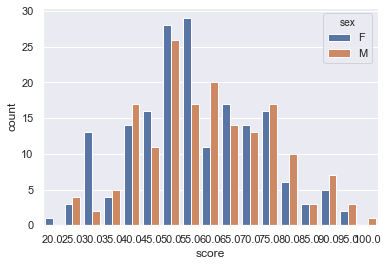

In [590]:
sns.countplot(x='score', hue='sex', data=df)

По ней видно, что среди девочек больший процент "средних" и "плохих" студентов, а мальчики в целом успешнее.

In [591]:
df_sex_m = df.loc[df.sex == 'M']
df_sex_f = df.loc[df.sex == 'F']

Проверим общий процент хорошистов/отличников

In [592]:
m_75 = df_sex_m[df_sex_m.score >= 75]
m_good_perc = round((m_75.score.count()*100)/df_sex_m.score.count(), 1)

f_75 = df_sex_f[df_sex_f.score >= 75]
f_good_perc = round((f_75.score.count()*100)/df_sex_f.score.count(), 1)

print('Процент хорошистов/отличников в школах - мальчики = {}, девочки = {}'.format(m_good_perc, f_good_perc))

Процент хорошистов/отличников в школах - мальчики = 24.1, девочки = 17.6


Видим, что в целом, по данным датасета, мальчики лучше справились с экзаменом.

# Возраст

Общее распределение:

count    358.000000
mean      16.659218
std        1.268476
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

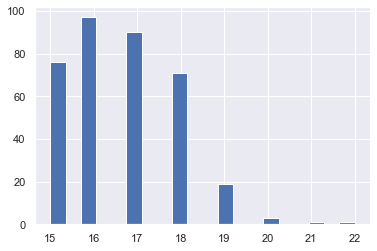

In [593]:
df.age.hist(bins=20)
df.age.describe()

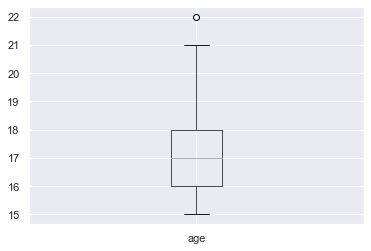

In [594]:
df.boxplot(column='age')

Основная возрастная группа от 16 до 18 лет. Минимум 15, максимум 21 (22 года выброс). Медиана 17 лет.


Посмотрим, как коррелируют между собой численные значения.

In [595]:
# используем ранее отсортированные числовые столбцы. И составим таблицу корреляций.
df_cor = df[numeric_columns]
cor = df_cor.corr()

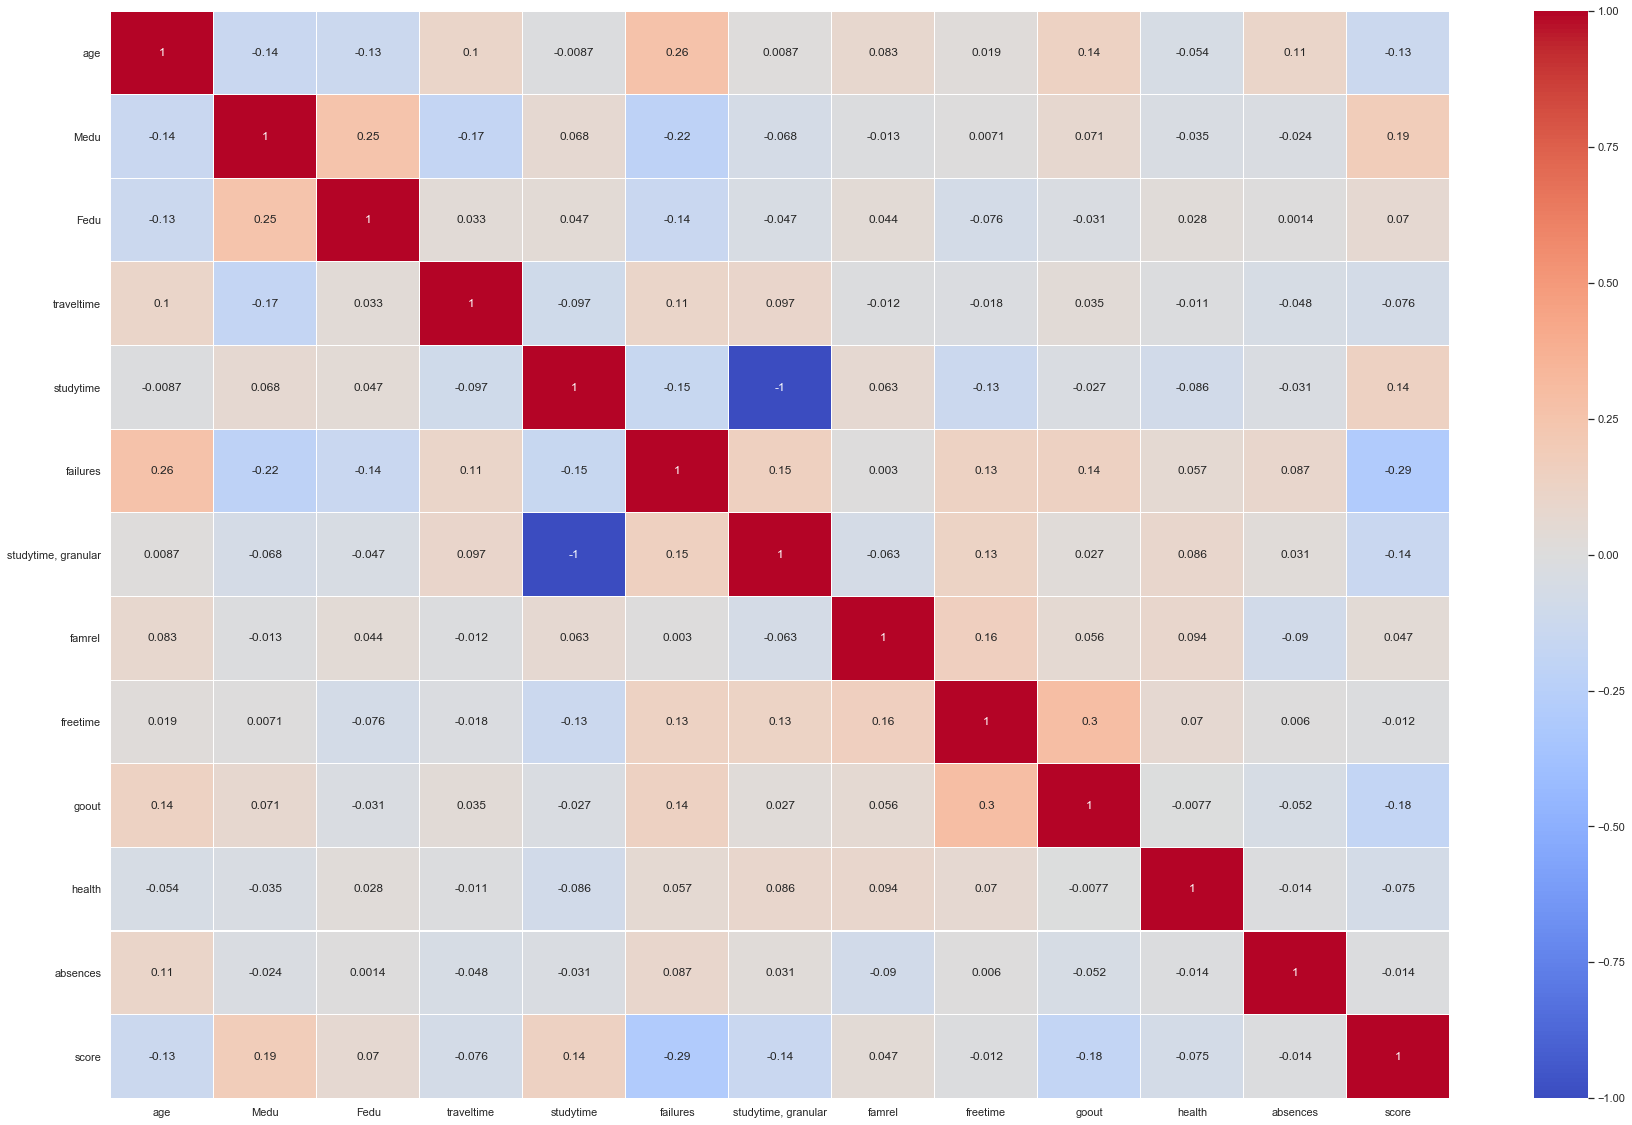

In [596]:
# для наглядности построим тепловую карту.
plt.subplots(figsize=(30, 20))
sns.heatmap(cor, annot=True, cmap='coolwarm', linewidths=0.1)

Смотрим тепловую карту. Видим положительные и отрицательные корриляции. Для наглядности выделяем интересующий нас параметр Score и сортируем влияния на него.

In [597]:
cor['score'].sort_values(ascending=False)

score                  1.000000
Medu                   0.186477
studytime              0.142055
Fedu                   0.069842
famrel                 0.046717
freetime              -0.012457
absences              -0.014039
health                -0.075340
traveltime            -0.075516
age                   -0.131542
studytime, granular   -0.142055
goout                 -0.182286
failures              -0.289377
Name: score, dtype: float64

1. Наибольшее положительное влияние оказывает образование матери и доп.учёба. В незначительной степени - образование отца и внутресемейные отношения. 
2. Интересующий в этом разделе возраст оказывает негативное влияние. Т.е. чем старше, тем хуже результат


# Адрес жительства

In [598]:
df.address.value_counts()

U    269
R     73
Name: address, dtype: int64

In [599]:
df.address.unique()
# видим пропуски в данных. Надо убрать

array(['U', nan, 'R'], dtype=object)

In [600]:
# воспользуемся заранее подготовленной функцией для удаления пропусков и NaN.
for col in ['address']:
    none_func(col)

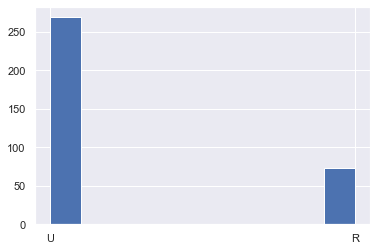

In [601]:
df.address.hist()

согласно гистограмме видно, что суммарно по школам превалируют городские адреса. Посмотрим, как они соотносятся с оценками

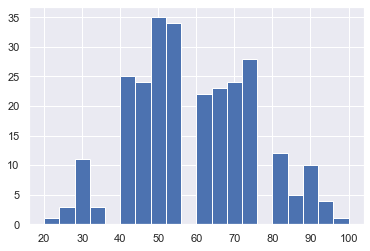

In [602]:
df_urban = df.loc[df.address == 'U']
df_urban.score.hist(bins=20)

count    265.000000
mean      58.830189
std       16.182828
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

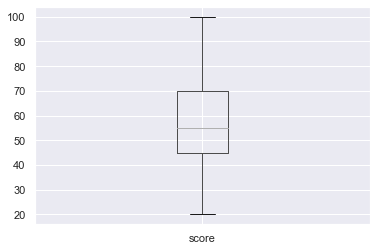

In [603]:
df_urban.boxplot(column='score')
df_urban.score.describe()

для городских учеников получилось распределение со смещением вправо. Основная масса располагается между 45 и 70 баллами.

Посмотрим, что там у деревенских

count    73.000000
mean     53.356164
std      16.203026
min      25.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

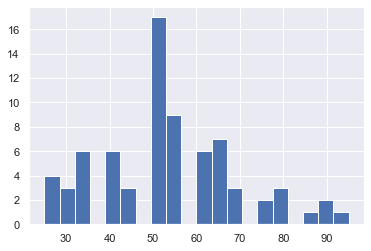

In [604]:
df_rur = df[df.address == 'R']
df_rur.score.hist(bins=20)
df_rur.score.describe()

count    73.000000
mean     53.356164
std      16.203026
min      25.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

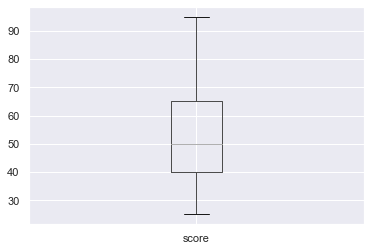

In [605]:
df_rur.boxplot(column='score')
df_rur.score.describe()

у деревенских основная масса между 40 и 65. Смещение правое.

Посмотрим, каков процент хорошистов/отличников

In [606]:
u_75 = df_urban[df_urban.score > 75]
u_good_perc = round((u_75.score.count()*100)/df_urban.score.count(), 1)

r_75 = df_rur[df_rur.score > 75]
r_good_perc = round((r_75.score.count()*100)/df_rur.score.count(), 1)

print('Процент хорошистов/отличников в школах - горожане = {}, деревенские = {}'.format(u_good_perc, r_good_perc))

Процент хорошистов/отличников в школах - горожане = 12.1, деревенские = 9.6


В целом городские поуверенее в плане учёбы. Хотя, возможно, сильно влияет разница в количествах.

# Размер семьи

In [607]:
df.famsize.value_counts()

GT3    234
LE3    100
Name: famsize, dtype: int64

насколько видно преобладают семьи с количеством членов > 3

In [608]:
df.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [609]:
# воспользуемся функцией, чтоб заполнить пропуски и заменить NaN на None
none_func('famsize')

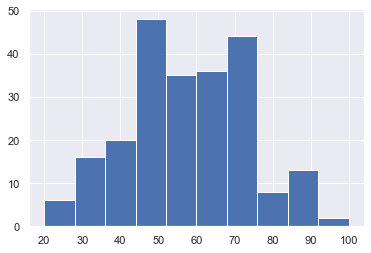

In [610]:
df_gt = df.loc[df.famsize == 'GT3']
df_gt.score.hist()

count    228.000000
mean      57.609649
std       16.097481
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

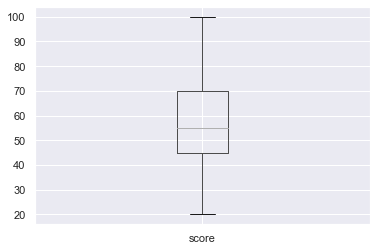

In [611]:
df_gt.boxplot(column='score')
df_gt.score.describe()

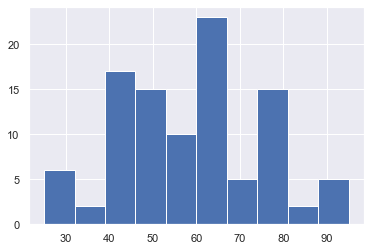

In [612]:
df_le = df.loc[df.famsize == 'LE3']
df_le.score.hist()

count    100.000000
mean      58.500000
std       16.197955
min       25.000000
25%       48.750000
50%       57.500000
75%       70.000000
max       95.000000
Name: score, dtype: float64

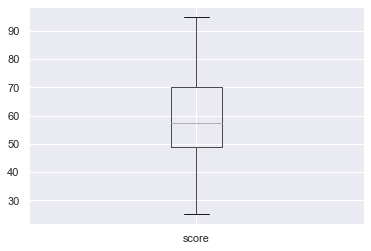

In [613]:
df_le.boxplot(column='score')
df_le.score.describe()

In [614]:
# сравним основные параметры между собой
df_le.score.describe() - df_gt.score.describe()

count   -128.000000
mean       0.890351
std        0.100474
min        5.000000
25%        3.750000
50%        2.500000
75%        0.000000
max       -5.000000
Name: score, dtype: float64

существенных отличий нет. Ученики из семей LE3 имеют лучше средний показатель, но ниже максимальный балл.

In [615]:
gt_75 = df_gt[df_gt.score > 75]
gt_good_perc = round((gt_75.score.count()*100)/df_gt.score.count(), 1)

le_75 = df_le[df_le.score > 75]
le_good_perc = round((le_75.score.count()*100)/df_le.score.count(), 1)

print('Процент хорошистов/отличников из семей - больше 3 = {}, меньше 3 = {}'.format(gt_good_perc, le_good_perc))

Процент хорошистов/отличников из семей - больше 3 = 10.1, меньше 3 = 13.0


Видимо в семьях с меньшим количеством членов уделяется больше внимания. 

Проверим, как коррелируют между собой внутресемейные отношения и оценки.

In [616]:
fam_score_gt = df_gt[['famrel', 'score']]

In [617]:
fam_score_gt.corr()

,famrel,score
famrel,1.000000,0.034094
score,0.034094,1.000000


In [618]:
fam_score_le = df_le[['famrel', 'score']]

In [619]:
fam_score_le.corr()

,famrel,score
famrel,1.000000,0.019054
score,0.019054,1.000000


однако, мы видим, что предположение о семейных отошениях не совсем верно, так как коэффициент корреляции выше для семей GT3.

In [620]:
fam_score_fedu_gt = df_gt[['Medu', 'score']]

In [621]:
fam_score_fedu_gt.corr()

,Medu,score
Medu,1.000000,0.180015
score,0.180015,1.000000


In [622]:
fam_score_fedu_le = df_le[['Medu', 'score']]

In [623]:
fam_score_fedu_le.corr()

,Medu,score
Medu,1.00000,0.20394
score,0.20394,1.00000


А вот значение корреляции для LE3, связанное с образованием матери, выше, чем ранее определенное для всего датасета. Возможно у матери больше времени для занятий с ребенком

# Pstatus (живут ли вместе родители)

In [624]:
df.Pstatus.unique()

array(['A', nan, 'T'], dtype=object)

In [625]:
df.Pstatus.value_counts()

T    283
A     34
Name: Pstatus, dtype: int64

In [626]:
# воспользуемся функцией для замены NaN и пропусков

In [627]:
none_func('Pstatus')

In [628]:
df_t = df.loc[df.Pstatus == 'T']

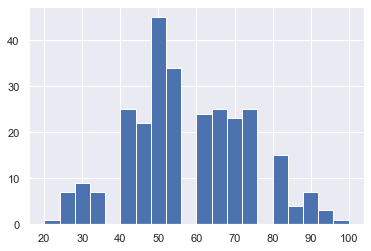

In [629]:
df_t.score.hist(bins=20)

count    277.000000
mean      57.490975
std       15.906341
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

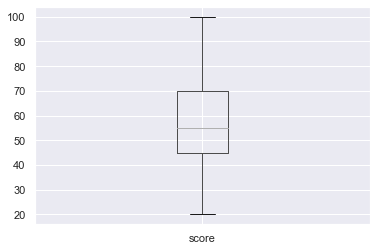

In [630]:
df_t.boxplot(column='score')
df_t.score.describe()

In [631]:
df_a = df.loc[df.Pstatus == 'A']

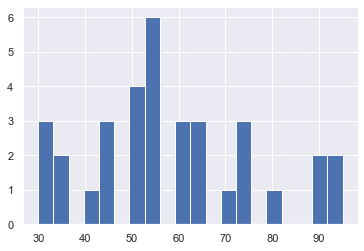

In [632]:
df_a.score.hist(bins=20)

count    34.000000
mean     58.382353
std      18.245821
min      30.000000
25%      46.250000
50%      55.000000
75%      68.750000
max      95.000000
Name: score, dtype: float64

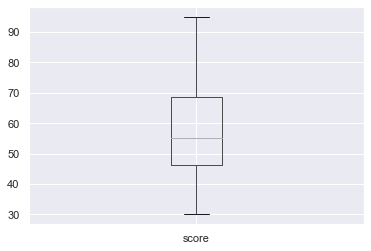

In [633]:
df_a.boxplot(column='score')
df_a.score.describe()

In [634]:
(df_a.score.describe() - df_t.score.describe())

count   -243.000000
mean       0.891378
std        2.339480
min       10.000000
25%        1.250000
50%        0.000000
75%       -1.250000
max       -5.000000
Name: score, dtype: float64

видно, что ребята из неполной семьи в среднем лучше, но в максимуме не дотягивают до учеников из полных семей.
Исходя из оценки корреляции, можно предположить, что в неполных семьях важную роль играет с кем проживает ученик.

Сейчас проверим корреляцию для полной семьи и далее для раздельных вариантов.

полная семья

In [635]:
# полная семья
cor_t = df_t.corr()
cor_t['score'].sort_values(ascending=False)

score                  1.000000
Medu                   0.214528
studytime              0.211239
Fedu                   0.100568
absences               0.044100
famrel                 0.018679
health                -0.027995
freetime              -0.060162
traveltime            -0.121112
age                   -0.145551
goout                 -0.199504
studytime, granular   -0.211239
failures              -0.310088
Name: score, dtype: float64

In [636]:
# опекун мама
df_gm = df.loc[df.guardian == 'mother']
# опекун папа
df_gf = df.loc[df.guardian == 'father']
# опекун кто либо ещё
df_go = df.loc[df.guardian == 'other']

In [637]:
guard_mother = df_gm[numeric_columns]
guard_father = df_gf[numeric_columns]
guard_other = df_go[numeric_columns]

In [638]:
cor_m = guard_mother.corr()
cor_f = guard_father.corr()
cor_o = guard_other.corr()

опекун мама

In [639]:
cor_m['score'].sort_values(ascending=False)

score                  1.000000
Medu                   0.184603
Fedu                   0.161278
studytime              0.079294
absences               0.023821
famrel                 0.009391
freetime              -0.022649
traveltime            -0.033037
studytime, granular   -0.079294
health                -0.131834
age                   -0.150805
goout                 -0.188404
failures              -0.281249
Name: score, dtype: float64

опекун папа

In [640]:
cor_f['score'].sort_values(ascending=False)

score                  1.000000
studytime              0.407307
Medu                   0.223089
famrel                 0.192715
health                 0.065618
Fedu                   0.044974
freetime              -0.030020
age                   -0.083424
traveltime            -0.108071
goout                 -0.120344
absences              -0.216764
failures              -0.354747
studytime, granular   -0.407307
Name: score, dtype: float64

опекун кто либо ещё

In [641]:
cor_o['score'].sort_values(ascending=False)

score                  1.000000
freetime               0.415420
famrel                 0.337869
Medu                   0.022761
health                 0.020951
age                    0.017351
studytime, granular    0.009239
studytime             -0.009239
Fedu                  -0.179244
absences              -0.191881
failures              -0.202273
goout                 -0.315296
traveltime            -0.386566
Name: score, dtype: float64

Итого: 
1. Для полной семьи очень сильное совокупное влияние образования мамы, папы и доп образования
2. если живет с мамой: наибольшее влияние образование матери и отца.
3. если живет с отцом: наибольшее влияние доп.занятия, образование матери и отношения в семье
4. если живет с кем то другим: наибольшее влияние свободное время(???) и отношение внутри семьи. 

# Дополнительная образовательная поддержка (Schoolsup)

In [642]:
df.schoolsup.unique()

array(['yes', 'no', nan], dtype=object)

In [643]:
# используем функцию
none_func('schoolsup')

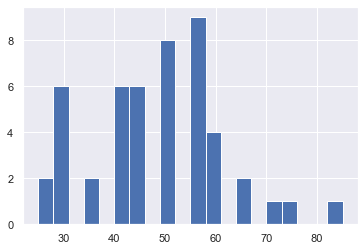

In [644]:
df_yes = df[df.schoolsup == 'yes']
df_yes.score.hist(bins=20)

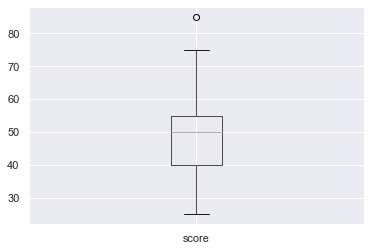

In [645]:
df_yes.boxplot(column='score')

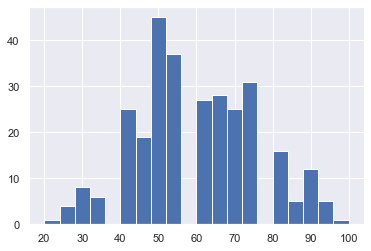

In [646]:
df_no = df[df.schoolsup == 'no']
df_no.score.hist(bins=20)

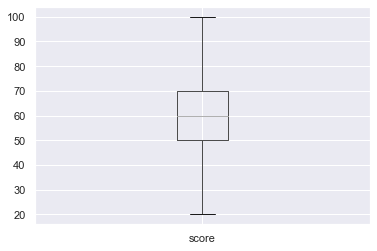

In [647]:
df_no.boxplot(column='score')

Ученики с поддержкой показали результат, распределение которого смещено влево. Общий результат настолько неважен, что единственный отличник стал "выбросом".
ученики без поддержки показали более стабильный результат, что странно, конечно же.
Возможно образовательная поддержка расчитана на совсем отстающих и безнадежных.

прежде чем провести оценку корреляции, необходимо избавиться от единственного выброса, чтоб он не утянул всю статистику. Мы знаем, что у него при 385 пропусках оценка 85. Наверно вундеркинд.

In [648]:
df_sup_yes = df_yes[numeric_columns]
df_sup = df_sup_yes.loc[df_sup_yes.score < 85]
corr_sup = df_sup.corr()
corr_sup.score.sort_values(ascending=False)

score                  1.000000
studytime, granular    0.251936
health                 0.135633
traveltime             0.029294
freetime              -0.017008
Fedu                  -0.023066
age                   -0.039912
famrel                -0.109868
failures              -0.111488
absences              -0.120301
Medu                  -0.170806
studytime             -0.251936
goout                 -0.342094
Name: score, dtype: float64

In [649]:
df_sup_no = df_no[numeric_columns]
corr_sup_no = df_sup_no.corr()
corr_sup_no.score.sort_values(ascending=False)

score                  1.000000
Medu                   0.206981
studytime              0.194218
Fedu                   0.080783
famrel                 0.070792
freetime              -0.006529
traveltime            -0.100420
health                -0.110267
absences              -0.180613
studytime, granular   -0.194218
goout                 -0.198126
age                   -0.218357
failures              -0.315673
Name: score, dtype: float64

У детей без образовательной поддержки роль по прежнему играет мама и доп занятия. У тех, кто получает от школы поддержку - играет роль непонятный параметр studytime, granular и здоровье.

Оценивать количественно не будем, поскольку разница почти в 6 раз, в пользу тех, кто не получает поддержку.

# Семейная поддержка (famsup)

In [650]:
df.famsup.unique()

array(['no', 'yes', nan], dtype=object)

In [651]:
# применим функцию
none_func('famsup')

In [652]:
famsup_yes = df.loc[df.famsup == 'yes']
famsup_no = df.loc[df.famsup == 'no']

In [653]:
df.famsup.value_counts()

yes    199
no     122
Name: famsup, dtype: int64

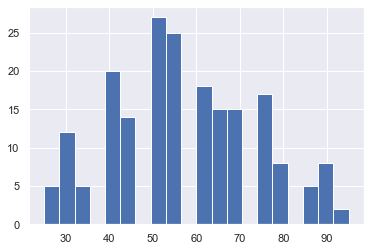

In [654]:
famsup_yes.score.hist(bins=20)

count    196.000000
mean      56.989796
std       16.706206
min       25.000000
25%       45.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64

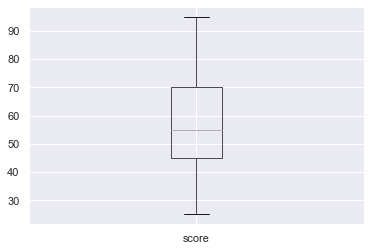

In [655]:
famsup_yes.boxplot(column='score')
famsup_yes.score.describe()

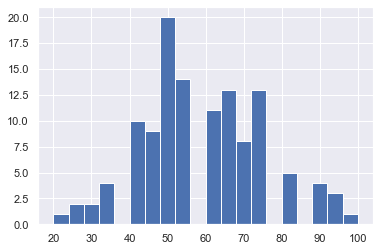

In [656]:
famsup_no.score.hist(bins=20)

count    120.000000
mean      58.583333
std       16.246310
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

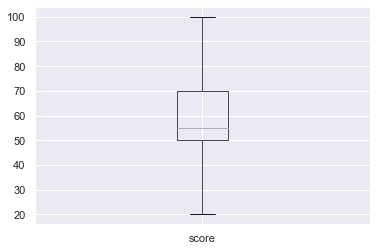

In [657]:
famsup_no.boxplot(column='score')
famsup_no.score.describe()

In [658]:
famsup_yes.score.describe() - famsup_no.score.describe()

count    76.000000
mean     -1.593537
std       0.459897
min       5.000000
25%      -5.000000
50%       0.000000
75%       0.000000
max      -5.000000
Name: score, dtype: float64

In [659]:
fam_yes = famsup_yes[numeric_columns]
corr_famsup_yes = fam_yes.corr()
corr_famsup_yes.score.sort_values(ascending=False)

score                  1.000000
Medu                   0.214921
studytime              0.199176
famrel                 0.102480
Fedu                   0.061942
freetime               0.018870
traveltime            -0.026229
health                -0.074400
age                   -0.105373
absences              -0.141226
studytime, granular   -0.199176
goout                 -0.218822
failures              -0.265640
Name: score, dtype: float64

In [660]:
fam_no = famsup_no[numeric_columns]
corr_famsup_no = fam_no.corr()
corr_famsup_no.score.sort_values(ascending=False)

score                  1.000000
Medu                   0.160718
Fedu                   0.132699
studytime              0.050085
famrel                -0.014753
freetime              -0.019698
studytime, granular   -0.050085
health                -0.059729
traveltime            -0.086085
goout                 -0.149508
age                   -0.190782
absences              -0.223552
failures              -0.359483
Name: score, dtype: float64

При наличии поддержки распределение оценок более симметрично, чем при отсутствии таковой. Согласно корреляционному анализу наибольшее влияние по прежжнему имеет образование матери и время, потраченное на доп. образование. 

# Paid

In [661]:
df.paid.unique()

array(['no', nan, 'yes'], dtype=object)

In [662]:
# уберем пропуски и NaN
none_func('paid')

In [663]:
df.paid.value_counts()

no     173
yes    148
Name: paid, dtype: int64

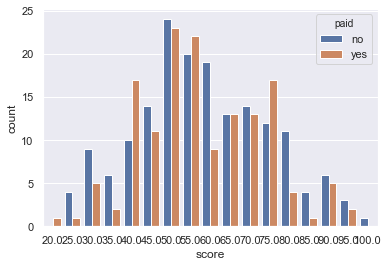

In [664]:
sns.countplot(x='score', hue='paid', data=df)

В случае со средним результатом наличие платных курсов даёт положительную динамику. 


In [665]:
paid_yes = df[df.paid == 'yes']
paid_no = df[df.paid == 'no']

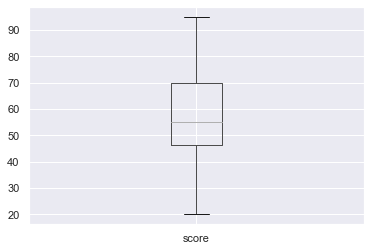

In [666]:
paid_yes.boxplot(column='score')

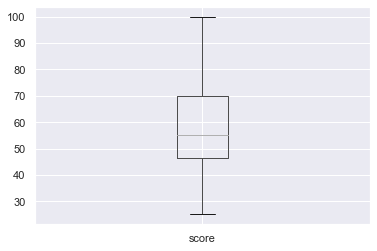

In [667]:
paid_no.boxplot(column='score')

In [668]:
paid_yes.score.describe() - paid_no.score.describe()

count   -24.000000
mean     -0.715955
std      -1.485183
min      -5.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      -5.000000
Name: score, dtype: float64

Интересно, что сравнение статистических параметров указывает на тот факт, что дети с обучением показывают результат хуже, чем без оного. Возможно дети с обучением по совокупности факторов слабее и без доп образования имели бы ещё хуже результаты.

# Activities (дополнительные кружки)

In [669]:
df.activities.unique()

array(['no', 'yes', nan], dtype=object)

In [670]:
# уберем пропуски
none_func('activities')

In [671]:
# распределение почти равномерно, 175 против 171
df.activities.value_counts()

yes    175
no     171
Name: activities, dtype: int64

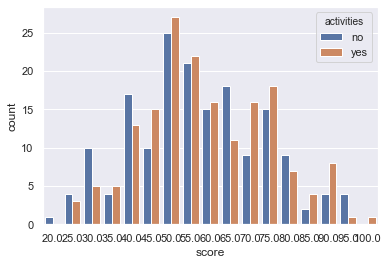

In [672]:
sns.countplot(x='score', hue='activities', data=df)

так как распределяются параметры почти поровну, то ограничимся общей оценкой. По ней видно, что активность в целом положительно сказывается на результатах учёбы. 

# nursery 

In [673]:
df.nursery.unique()

array(['yes', 'no', nan], dtype=object)

In [674]:
none_func('nursery')

In [675]:
df.nursery.value_counts()

yes    275
no      70
Name: nursery, dtype: int64

In [676]:
df_ny = df[df.nursery == 'yes']
df_nn = df[df.nursery == 'no']

count    272.000000
mean      57.830882
std       16.809133
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

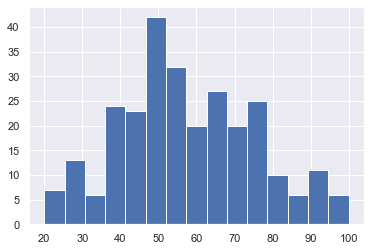

In [677]:
df_ny.score.hist(bins=15)
df_ny.score.describe()

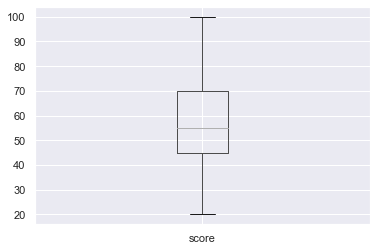

In [678]:
df_ny.boxplot(column='score')

count    68.000000
mean     56.617647
std      13.914482
min      25.000000
25%      50.000000
50%      55.000000
75%      66.250000
max      90.000000
Name: score, dtype: float64

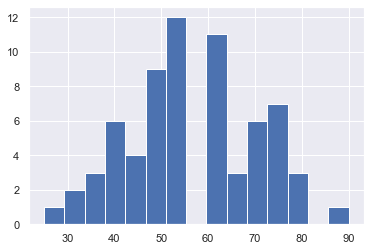

In [679]:
df_nn.score.hist(bins=15)
df_nn.score.describe()

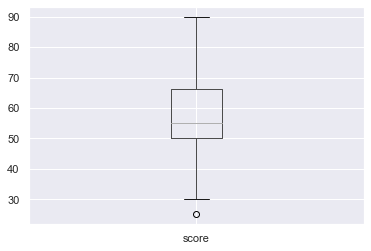

In [680]:
df_nn.boxplot(column='score')

In [681]:
df_ny.score.describe() - df_nn.score.describe()

count    204.000000
mean       1.213235
std        2.894650
min       -5.000000
25%       -5.000000
50%        0.000000
75%        3.750000
max       10.000000
Name: score, dtype: float64

Те, кто посещал детсад, показывают лучше результаты в целом.

# higher

желание получить высшее образование должно, по идее, хорошо отражаться на результатах. Проверим

In [682]:
none_func('higher')

In [683]:
df.higher.unique()

array(['yes', None, 'no'], dtype=object)

In [684]:
high_yes = df[df.higher == 'yes']
high_no = df[df.higher == 'no']

In [685]:
df.higher.value_counts()

yes    326
no      13
Name: higher, dtype: int64

Соотношение 326 к 13 в пользу желающих, вряд ли даст понимание влияния этого самого желания высшего образования.

# internet

In [686]:
none_func('internet')

In [687]:
df.internet.value_counts()

yes    279
no      50
Name: internet, dtype: int64

In [688]:
inter_yes = df[df.internet == 'yes']
inter_no = df[df.internet == 'no']

count    274.000000
mean      58.156934
std       16.424347
min       20.000000
25%       46.250000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

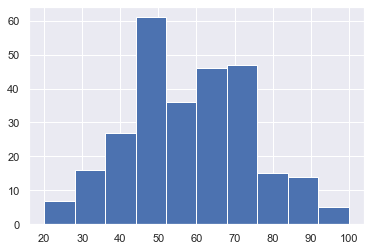

In [689]:
inter_yes.score.hist(bins=10)
inter_yes.score.describe()

count    49.000000
mean     55.102041
std      14.415335
min      30.000000
25%      45.000000
50%      55.000000
75%      65.000000
max      90.000000
Name: score, dtype: float64

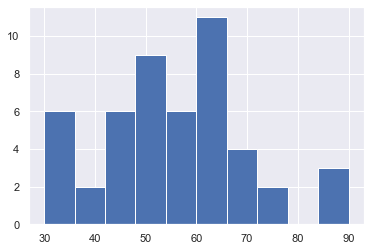

In [690]:
inter_no.score.hist(bins=10)
inter_no.score.describe()

In [691]:
inter_yes.score.describe() - inter_no.score.describe()

count    225.000000
mean       3.054893
std        2.009012
min      -10.000000
25%        1.250000
50%        0.000000
75%        5.000000
max       10.000000
Name: score, dtype: float64

простым сравнением видим, что наличие интернета положительно сказывается. Что логично.

# romantic

In [692]:
df.romantic.value_counts()

no     224
yes    105
Name: romantic, dtype: int64

In [693]:
df.romantic.unique()

array(['no', nan, 'yes'], dtype=object)

In [694]:
none_func('romantic')

In [695]:
rom_yes = df[df.romantic == 'yes']
rom_no = df[df.romantic == 'no']

In [696]:
rom_score = rom_yes[['romantic', 'score']]
score_rom = rom_no[['romantic', 'score']]

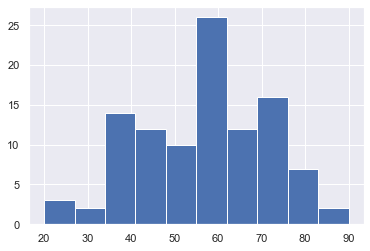

In [697]:
rom_yes.score.hist(bins=10)

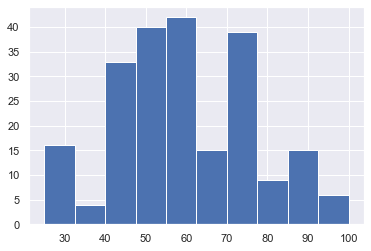

In [698]:
rom_no.score.hist(bins=10)

In [699]:
rom_yes.score.describe() - rom_no.score.describe()

count   -115.000000
mean      -2.167413
std       -2.269122
min       -5.000000
25%       -5.000000
50%        0.000000
75%       -5.000000
max      -10.000000
Name: score, dtype: float64

простым сравнением видим, что наличие отношений отвлекает учеников и они показывают в среднем худший результат

# Guardian

опекун был рассмотрен ранее, в разделе про полную/неполную семью

# Анализ номинативных переменных

Номинативные переменные, которые осталось рассмотреть: **Medu, Fedu, Mjob, Fjob, reason, traveltime, studytime, failures, famrel, freetime, goout, health, absences**.

In [700]:
df.Fedu.value_counts()
# в датасете ошибка. 40 вместо 4.0

2.0     95
3.0     91
4.0     80
1.0     68
0.0      2
40.0     1
Name: Fedu, dtype: int64

In [701]:
df.Fedu = df.Fedu.replace(40.0, 4.0)

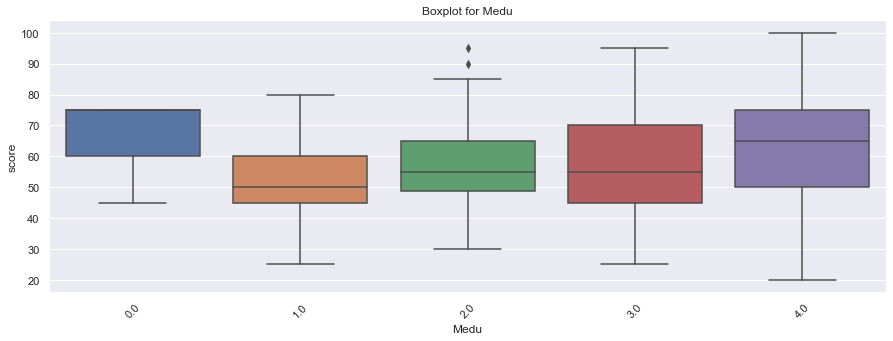

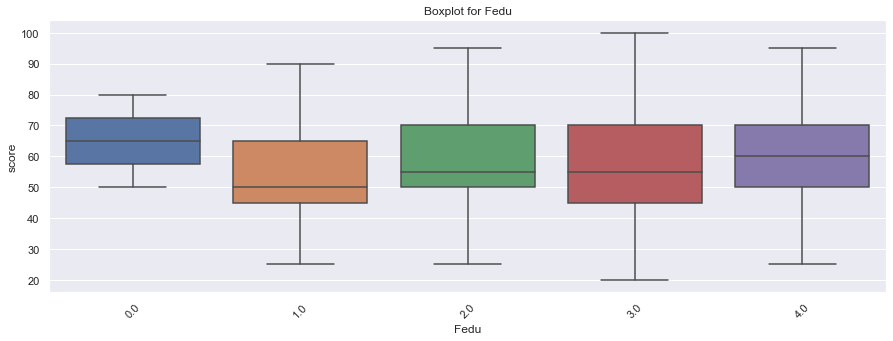

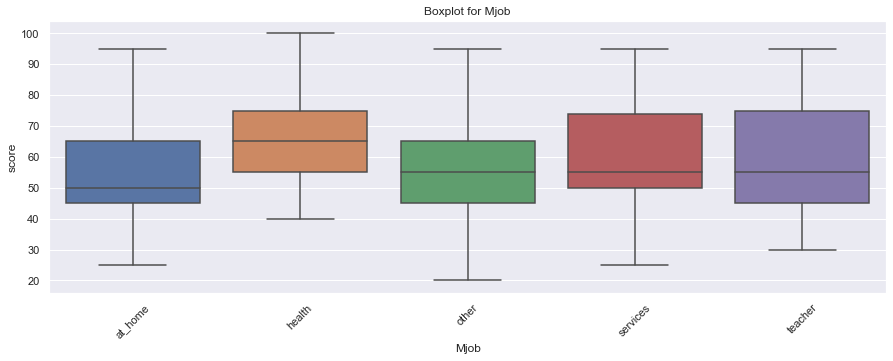

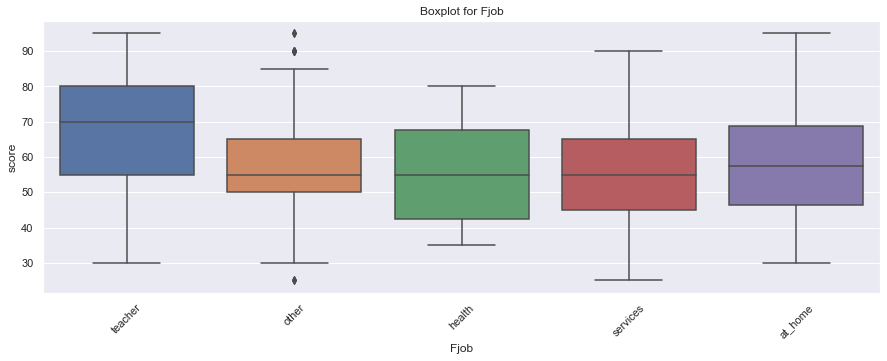

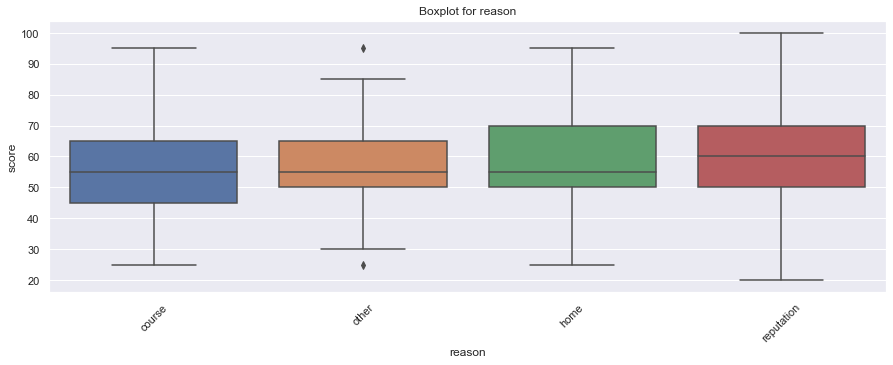

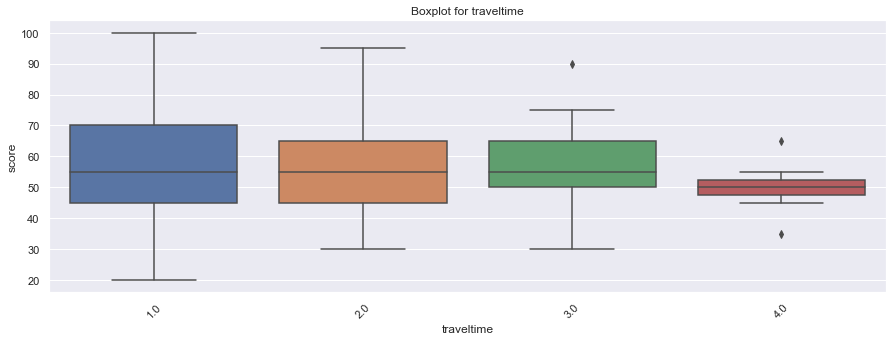

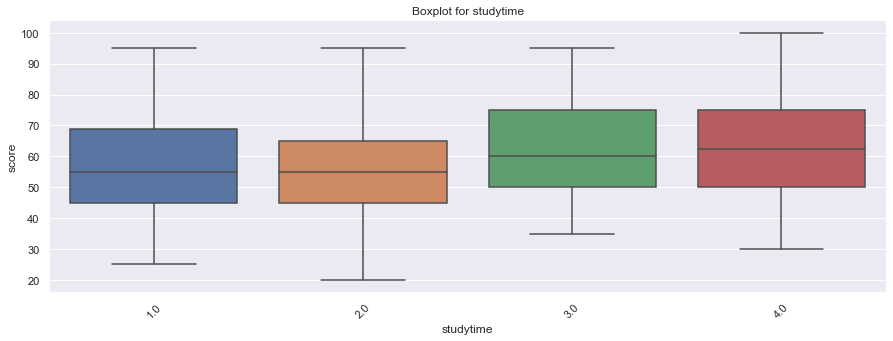

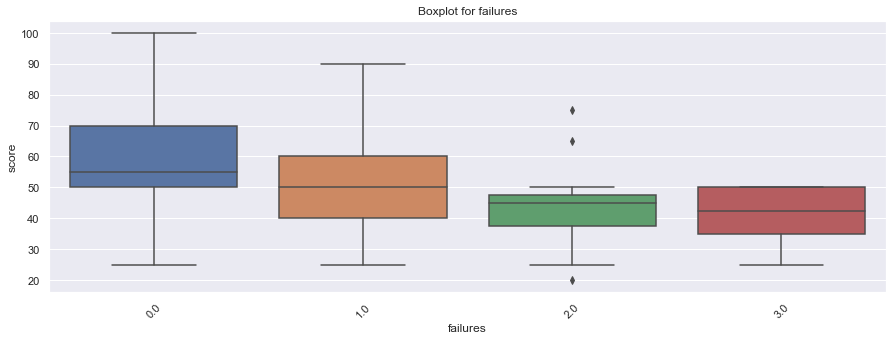

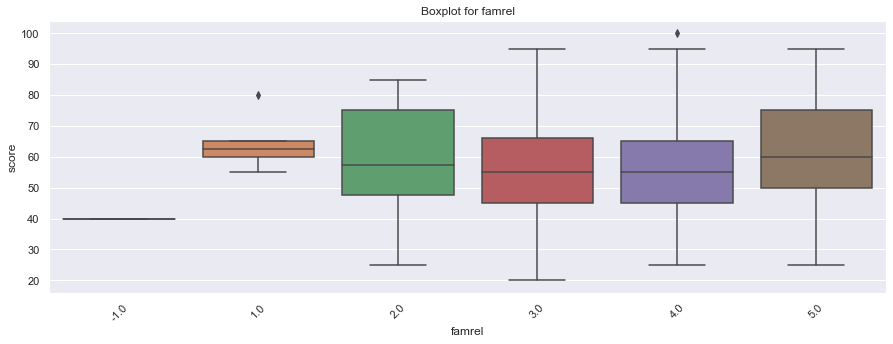

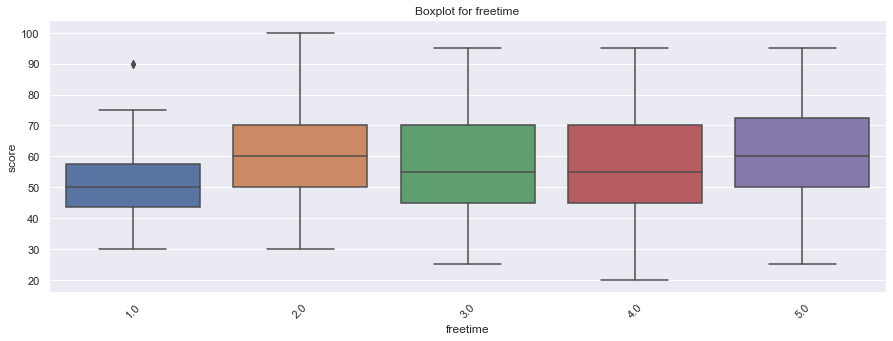

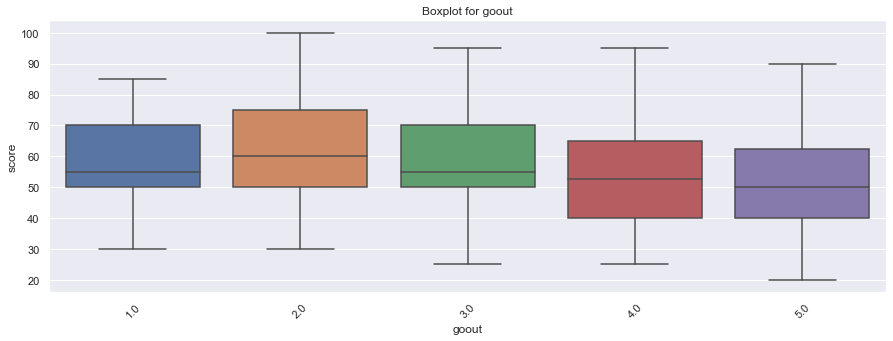

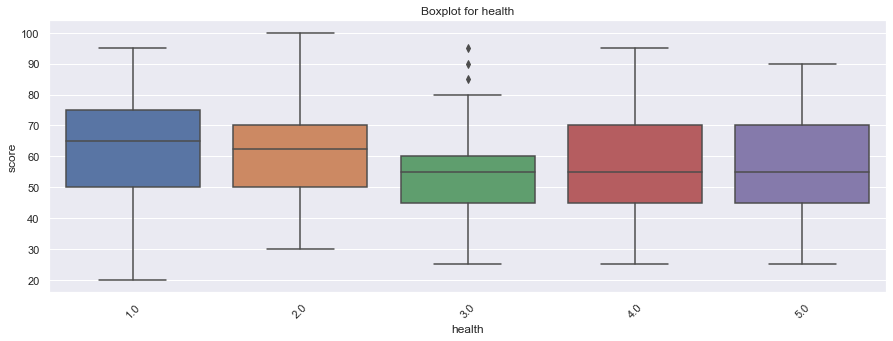

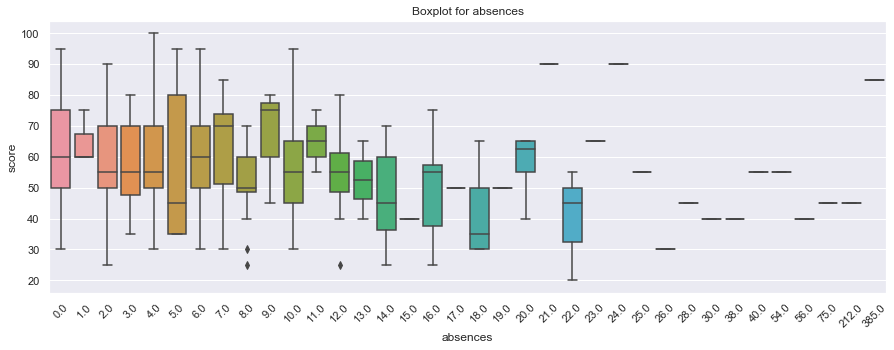

In [702]:
import warnings
warnings.simplefilter('ignore')
sns.set()

for col in ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures',
            'famrel', 'freetime', 'goout', 'health', 'absences']:
    df_boxplot(col)

Оценка влияния номинативных параметров:
1. Medu - очевидно, что влияние образования матери достаточно сильное. Это было не раз показано ранее при корреляционном анализе
2. Fedu - влияние образования отца не такое уж и сильное, тем не менее имеет место быть
3. Mjob - работа матери оказывает незначительное влияние. Ранее мы выяснили, что параметр здоровья влияет в некоторых ситуациях. Здесь мы видим, что занятость мамы в здравоохранении более ярко выражено, чем все остальные представленные профессии
4. Fjob -работа отца. Сразу видно, что если папа учитель - значит будет учить. 
5. Reason - не сильно выделяющееся значение репутации школы. Вполне логично, что школа имеющая хорошую репутацию, имеет более качественный преподавательский состав и следовательно образование качественней.
6. Travel time - очевидно, что дальняя дорога выматывает. Те, кому ехать дальше всех,уплотнились в районе медианы оценки.
7. Studytime - очевидный и отличный восходящий тренд. Больше труда - лучше оценки. 
8. Failures - логично, что чем больше неудач вне школы, тем хуже средний балл.
9. Famrel - достаточно странное влияине, без четко прослеживаемой логики. К тому же, видимо, попала ошибка в датасет, со значением -1.
10. Freetime - удивительно, но наличие свободного времениотчасти положительно влияет. Возможно, если его тратить на доп занятия и различные активности.
11. Goout - время с друзьями. Отрицательное влияние. Всё логично
12. Health - странным образом влияет только на определенные группы учеников. Общей тенденции нет.
13. Absences - пропуски. Видимо всё очень индивидуально, так как общей тенденции нет.

Проверим нулевую гипотезу о том, что распределения экзаменационных оценок по различным параметрам неразличимы:

In [703]:
for col in ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'traveltime', 'studytime', 'failures',
            'famrel', 'freetime', 'goout', 'health', 'absences']:
    df_stat_dif(col)

Найдены статистически значимые различия для колонки Mjob


Видимо значение влияние работы матери проявилось в том самом здравоохранении. Тем не менее для модели я бы оставил следующие столбцы:

In [704]:
df_for_model = df.loc[:, ['Medu', 'Mjob', 'Fjob',
                          'traveltime', 'studytime', 'failures']]
df_for_model.head(5)

,Medu,Mjob,Fjob,traveltime,studytime,failures
0,4.0,at_home,teacher,2.0,2.0,0.0
1,1.0,at_home,other,1.0,2.0,0.0
2,1.0,at_home,other,1.0,2.0,3.0
3,4.0,health,NaN,1.0,3.0,0.0
4,3.0,other,other,1.0,2.0,0.0


Вывод: 
- для успешной учебы надо:
    1. Учиться в школе GP
    2. Быть мальчиком
    3. Возраст от 16 до 18 лет
    4. Жить в городе
    5. Воспитываться в полной семье
    6. Мама - врач
    7. Папа - учитель
    8. Побольше времени на саморазвитие
    9. Не иметь учебной поддержки со стороны школы, что говорит об успешности в учёбе и общей эрудированности.
    10. Различные активности. Это всегда положительно сказывается.
    11. Дети, посещавшие детсад, более социальны и, соответственно, проще приспосабливаются к условиям, благодаря развитым навыкам коммуникации
    12. Интернет дома. Доступ к любой информации делает проще подготовку к экзаменам и расширяет мировозрение.
    13. Не злоупотреблять общением с друзьями в ущерб учебному процессу.
    
Для более глубокого изучения требуется разбивка датасета на подгруппы с выявлением всех взаимосвязей между параметрами, финально влияющих на оценку.

Колонка пропусков не несет особой смысловой нагрузки без данных об общей успеваемости. Только лишь оценка за экзамен не особо коррелирует. Неплохо было бы иметь средний балл за периоды, чтоб можно было соотнести общую успеваемость с пропусками.